# BUSI Dataset Training Pipeline

**Author:** Reza Mirzaeifard, PhD
**Email:** reza.mirzaeifard@gmail.com
**Project:** Ultrasound Imaging Toolkit for InPhase Solutions AS

---

## Overview

This notebook implements the complete training pipeline for breast ultrasound image analysis:

1. **Download & Prepare BUSI Dataset** (780 clinical images)
2. **Train U-Net for Lesion Segmentation**
3. **Train ResNet for Classification** (Benign vs Malignant)
4. **Evaluate & Visualize Results**

### BUSI Dataset

| Category | Images | Description |
|----------|--------|-------------|
| Benign | 437 | Non-cancerous lesions |
| Malignant | 210 | Cancerous tumors |
| Normal | 133 | Healthy tissue |
| **Total** | **780** | With segmentation masks |

---
## 1. Environment Setup

In [2]:
import sys
from pathlib import Path

# Configure paths
project_root = Path('.').absolute().parent
src_path = project_root / 'src'
data_path = project_root / 'data' / 'busi'

if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"✓ Using device: {device}")
print(f"✓ Project root: {project_root}")
print(f"✓ Data path: {data_path}")

# Visualization style
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    pass

✓ Using device: cpu
✓ Project root: /Users/rezami/PycharmProjects/inPhase
✓ Data path: /Users/rezami/PycharmProjects/inPhase/data/busi


---
## 2. Download BUSI Dataset

The dataset will be downloaded from Kaggle. You need:
1. Kaggle account
2. API token in `~/.kaggle/kaggle.json`

Or download manually from: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset

In [ ]:
def download_busi_dataset():
    """Download BUSI dataset from Kaggle."""
    import shutil

    data_path.mkdir(parents=True, exist_ok=True)

    # Check if already exists
    if (data_path / "benign").exists() and len(list((data_path / "benign").glob("*.png"))) > 0:
        print("✓ BUSI dataset already downloaded")
        return True

    print("Downloading BUSI dataset from Kaggle...")

    try:
        from kaggle.api.kaggle_api_extended import KaggleApi
        api = KaggleApi()
        api.authenticate()

        api.dataset_download_files(
            'aryashah2k/breast-ultrasound-images-dataset',
            path=str(data_path),
            unzip=True
        )

        # Reorganize if needed
        dataset_subdir = data_path / "Dataset_BUSI_with_GT"
        if dataset_subdir.exists():
            for folder in ["benign", "malignant", "normal"]:
                src = dataset_subdir / folder
                dst = data_path / folder
                if src.exists() and not dst.exists():
                    shutil.move(str(src), str(dst))
            if dataset_subdir.exists():
                shutil.rmtree(dataset_subdir)

        print("✓ Download complete")
        return True

    except Exception as e:
        print(f"⚠ Kaggle download failed: {e}")
        print("\nManual download instructions:")
        print("1. Visit: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset")
        print("2. Download and extract to: data/busi/")
        print("3. Ensure structure: data/busi/{benign,malignant,normal}/")
        return False

# Download dataset
download_busi_dataset()

In [3]:
def verify_dataset():
    """Verify dataset and show statistics."""
    print("\nDataset Statistics:")
    print("=" * 50)

    stats = {}
    for category in ["benign", "malignant", "normal"]:
        folder = data_path / category
        if folder.exists():
            # Get images (exclude masks)
            images = [f for f in folder.glob("*.png") if "_mask" not in f.stem]
            masks = [f for f in folder.glob("*_mask*.png")]
            stats[category] = {"images": len(images), "masks": len(masks)}
            print(f"  {category.capitalize():12} {len(images):4} images, {len(masks):4} masks")
        else:
            print(f"  {category.capitalize():12} NOT FOUND")
            stats[category] = {"images": 0, "masks": 0}

    total = sum(s["images"] for s in stats.values())
    print(f"  {'Total':12} {total:4} images")
    return stats

stats = verify_dataset()


Dataset Statistics:
  Benign        437 images,  454 masks
  Malignant     210 images,  211 masks
  Normal        133 images,  133 masks
  Total         780 images


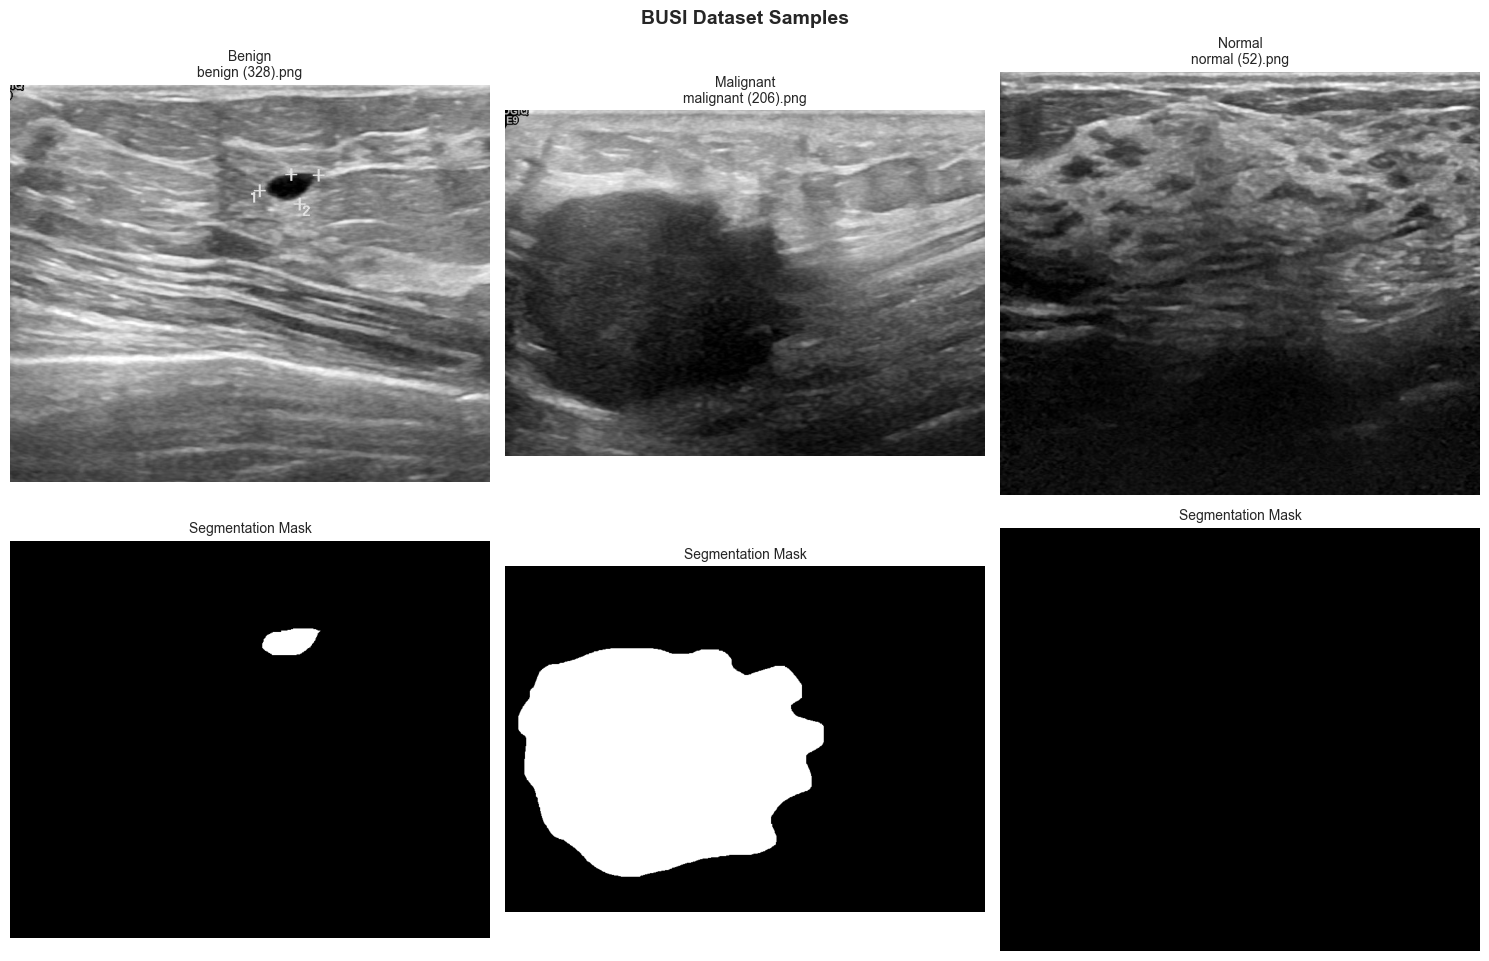

In [4]:
# Visualize sample images
def show_sample_images():
    """Display sample images from each category."""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    categories = ["benign", "malignant", "normal"]

    for i, category in enumerate(categories):
        folder = data_path / category
        if not folder.exists():
            continue

        # Get a sample image
        images = [f for f in folder.glob("*.png") if "_mask" not in f.stem]
        if len(images) == 0:
            continue

        img_path = images[0]
        mask_paths = list(folder.glob(f"{img_path.stem}_mask*.png"))

        # Load and display image
        img = np.array(Image.open(img_path))
        axes[0, i].imshow(img, cmap='gray' if img.ndim == 2 else None)
        axes[0, i].set_title(f'{category.capitalize()}\n{img_path.name}', fontsize=10)
        axes[0, i].axis('off')

        # Load and display mask
        if mask_paths:
            mask = np.array(Image.open(mask_paths[0]))
            axes[1, i].imshow(mask, cmap='gray')
            axes[1, i].set_title(f'Segmentation Mask', fontsize=10)
        else:
            axes[1, i].text(0.5, 0.5, 'No mask', ha='center', va='center')
        axes[1, i].axis('off')

    plt.suptitle('BUSI Dataset Samples', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

show_sample_images()

---
## 3. Data Preparation

Create PyTorch datasets for:
- **Segmentation:** Image → Mask pairs
- **Classification:** Image → Label (benign/malignant)

In [5]:
class BUSISegmentationDataset(Dataset):
    """Dataset for lesion segmentation."""

    def __init__(self, data_dir, categories=["benign", "malignant"],
                 transform=None, mask_transform=None, img_size=(256, 256)):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.mask_transform = mask_transform
        self.img_size = img_size

        self.samples = []
        for category in categories:
            folder = self.data_dir / category
            if not folder.exists():
                continue

            for img_path in folder.glob("*.png"):
                if "_mask" in img_path.stem:
                    continue

                # Find corresponding mask
                mask_paths = list(folder.glob(f"{img_path.stem}_mask*.png"))
                if mask_paths:
                    self.samples.append({
                        "image": img_path,
                        "mask": mask_paths[0],
                        "category": category
                    })

        print(f"✓ Loaded {len(self.samples)} image-mask pairs for segmentation")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Load image
        image = Image.open(sample["image"]).convert("RGB")
        image = image.resize(self.img_size, Image.BILINEAR)

        # Load mask
        mask = Image.open(sample["mask"]).convert("L")
        mask = mask.resize(self.img_size, Image.NEAREST)

        # Convert to tensors
        image = transforms.ToTensor()(image)
        mask = transforms.ToTensor()(mask)
        mask = (mask > 0.5).float()  # Binarize

        if self.transform:
            image = self.transform(image)

        return image, mask


class BUSIClassificationDataset(Dataset):
    """Dataset for benign vs malignant classification."""

    def __init__(self, data_dir, transform=None, img_size=(224, 224)):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.img_size = img_size

        self.samples = []
        self.class_to_idx = {"benign": 0, "malignant": 1}

        for category in ["benign", "malignant"]:
            folder = self.data_dir / category
            if not folder.exists():
                continue

            for img_path in folder.glob("*.png"):
                if "_mask" in img_path.stem:
                    continue
                self.samples.append({
                    "image": img_path,
                    "label": self.class_to_idx[category],
                    "category": category
                })

        # Count per class
        counts = {k: sum(1 for s in self.samples if s["label"] == v)
                  for k, v in self.class_to_idx.items()}
        print(f"✓ Loaded {len(self.samples)} images for classification")
        print(f"  Benign: {counts['benign']}, Malignant: {counts['malignant']}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        image = Image.open(sample["image"]).convert("RGB")
        image = image.resize(self.img_size, Image.BILINEAR)
        image = transforms.ToTensor()(image)

        if self.transform:
            image = self.transform(image)

        return image, sample["label"]


# Create datasets
seg_dataset = BUSISegmentationDataset(data_path)
cls_dataset = BUSIClassificationDataset(data_path)

✓ Loaded 647 image-mask pairs for segmentation
✓ Loaded 647 images for classification
  Benign: 437, Malignant: 210


---
## 4. Train U-Net for Segmentation

In [6]:
from ultrasound.models.unet import UNet

def dice_loss(pred, target, smooth=1e-6):
    """Dice loss for segmentation."""
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()


def dice_coefficient(pred, target, threshold=0.5):
    """Calculate Dice coefficient."""
    pred = (torch.sigmoid(pred) > threshold).float()
    intersection = (pred * target).sum()
    return (2 * intersection) / (pred.sum() + target.sum() + 1e-6)


def train_segmentation_model(dataset, epochs=20, batch_size=8, lr=1e-4):
    """Train U-Net for lesion segmentation."""

    # Split dataset
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    print(f"\nTraining Segmentation Model")
    print(f"{'='*50}")
    print(f"Train samples: {len(train_dataset)}")
    print(f"Val samples:   {len(val_dataset)}")
    print(f"Epochs:        {epochs}")
    print(f"Batch size:    {batch_size}")
    print(f"Learning rate: {lr}")
    print(f"Device:        {device}")

    # Create model
    model = UNet(in_channels=3, out_channels=1, features=[64, 128, 256, 512])
    model = model.to(device)

    # Loss and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

    # Training history
    history = {"train_loss": [], "val_loss": [], "val_dice": []}
    best_dice = 0

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks) + dice_loss(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        val_dice = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                val_loss += (criterion(outputs, masks) + dice_loss(outputs, masks)).item()
                val_dice += dice_coefficient(outputs, masks).item()

        val_loss /= len(val_loader)
        val_dice /= len(val_loader)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_dice"].append(val_dice)

        scheduler.step(val_loss)

        print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")

        # Save best model
        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(model.state_dict(), project_root / "models" / "unet_busi_best.pth")

    print(f"\n✓ Best Validation Dice: {best_dice:.4f}")
    return model, history

# Create models directory
(project_root / "models").mkdir(exist_ok=True)

# Train (reduced epochs for demo - increase for better results)
seg_model, seg_history = train_segmentation_model(seg_dataset, epochs=10, batch_size=4)


Training Segmentation Model
Train samples: 517
Val samples:   130
Epochs:        10
Batch size:    4
Learning rate: 0.0001
Device:        cpu


Epoch 1/10: 100%|██████████| 130/130 [18:32<00:00,  8.56s/it]


  Train Loss: 1.2013 | Val Loss: 1.1550 | Val Dice: 0.4926


Epoch 2/10: 100%|██████████| 130/130 [14:32<00:00,  6.71s/it]


  Train Loss: 1.0248 | Val Loss: 0.9685 | Val Dice: 0.5771


Epoch 3/10: 100%|██████████| 130/130 [15:51<00:00,  7.32s/it]


  Train Loss: 0.9431 | Val Loss: 0.9014 | Val Dice: 0.6203


Epoch 4/10: 100%|██████████| 130/130 [16:57<00:00,  7.83s/it]


  Train Loss: 0.8846 | Val Loss: 0.8945 | Val Dice: 0.5860


Epoch 5/10: 100%|██████████| 130/130 [14:27<00:00,  6.67s/it]


  Train Loss: 0.8173 | Val Loss: 0.8798 | Val Dice: 0.5638


Epoch 6/10: 100%|██████████| 130/130 [11:40<00:00,  5.39s/it]


  Train Loss: 0.7704 | Val Loss: 0.8432 | Val Dice: 0.6039


Epoch 7/10: 100%|██████████| 130/130 [11:59<00:00,  5.54s/it]


  Train Loss: 0.7123 | Val Loss: 0.7909 | Val Dice: 0.6055


Epoch 8/10: 100%|██████████| 130/130 [11:55<00:00,  5.50s/it]


  Train Loss: 0.6686 | Val Loss: 0.7418 | Val Dice: 0.6345


Epoch 9/10: 100%|██████████| 130/130 [11:48<00:00,  5.45s/it]


  Train Loss: 0.6153 | Val Loss: 0.7115 | Val Dice: 0.6188


Epoch 10/10: 100%|██████████| 130/130 [11:48<00:00,  5.45s/it]


  Train Loss: 0.5951 | Val Loss: 0.6513 | Val Dice: 0.6512

✓ Best Validation Dice: 0.6512


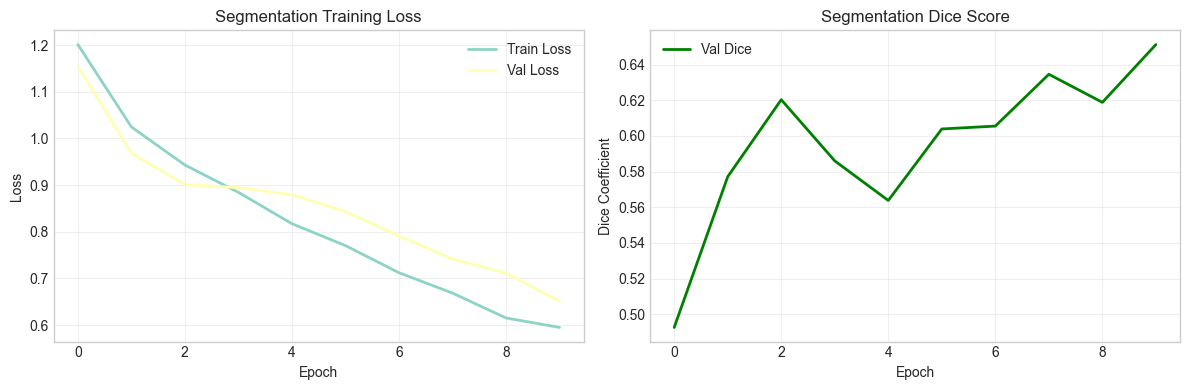

In [7]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(seg_history["train_loss"], label="Train Loss", linewidth=2)
axes[0].plot(seg_history["val_loss"], label="Val Loss", linewidth=2)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Segmentation Training Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(seg_history["val_dice"], label="Val Dice", linewidth=2, color='green')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Dice Coefficient")
axes[1].set_title("Segmentation Dice Score")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / "outputs" / "segmentation_training.png", dpi=150)
plt.show()

---
## 5. Train ResNet for Classification

In [8]:
from ultrasound.models.classifier import ResNetClassifier

def train_classification_model(dataset, epochs=20, batch_size=16, lr=1e-4):
    """Train ResNet for benign vs malignant classification."""

    # Split dataset
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    print(f"\nTraining Classification Model")
    print(f"{'='*50}")
    print(f"Train samples: {len(train_dataset)}")
    print(f"Val samples:   {len(val_dataset)}")
    print(f"Epochs:        {epochs}")
    print(f"Batch size:    {batch_size}")

    # Create model with transfer learning
    model = ResNetClassifier(
        num_classes=2,
        pretrained=True,
        model_name='resnet18',
        freeze_backbone=False  # Fine-tune all layers
    )
    model = model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

    # Training history
    history = {"train_loss": [], "val_loss": [], "val_acc": []}
    best_acc = 0

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct / total

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        scheduler.step(val_loss)

        print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), project_root / "models" / "resnet_busi_best.pth")

    print(f"\n✓ Best Validation Accuracy: {best_acc:.4f}")
    return model, history

# Train classification model
cls_model, cls_history = train_classification_model(cls_dataset, epochs=10, batch_size=8)


Training Classification Model
Train samples: 517
Val samples:   130
Epochs:        10
Batch size:    8


Epoch 1/10: 100%|██████████| 65/65 [01:00<00:00,  1.08it/s]


  Train Loss: 0.4560 | Val Loss: 0.3914 | Val Acc: 0.8154


Epoch 2/10: 100%|██████████| 65/65 [00:58<00:00,  1.11it/s]


  Train Loss: 0.2105 | Val Loss: 0.2627 | Val Acc: 0.8692


Epoch 3/10: 100%|██████████| 65/65 [00:55<00:00,  1.18it/s]


  Train Loss: 0.1375 | Val Loss: 0.3473 | Val Acc: 0.8462


Epoch 4/10: 100%|██████████| 65/65 [00:55<00:00,  1.16it/s]


  Train Loss: 0.1249 | Val Loss: 0.3064 | Val Acc: 0.8846


Epoch 5/10: 100%|██████████| 65/65 [00:55<00:00,  1.16it/s]


  Train Loss: 0.0948 | Val Loss: 0.3700 | Val Acc: 0.8692


Epoch 6/10: 100%|██████████| 65/65 [00:57<00:00,  1.13it/s]


  Train Loss: 0.0685 | Val Loss: 0.3230 | Val Acc: 0.8846


Epoch 7/10: 100%|██████████| 65/65 [00:55<00:00,  1.17it/s]


  Train Loss: 0.0637 | Val Loss: 0.3066 | Val Acc: 0.8692


Epoch 8/10: 100%|██████████| 65/65 [00:55<00:00,  1.16it/s]


  Train Loss: 0.0296 | Val Loss: 0.3753 | Val Acc: 0.8923


Epoch 9/10: 100%|██████████| 65/65 [00:56<00:00,  1.15it/s]


  Train Loss: 0.0205 | Val Loss: 0.3948 | Val Acc: 0.8615


Epoch 10/10: 100%|██████████| 65/65 [00:55<00:00,  1.17it/s]


  Train Loss: 0.0263 | Val Loss: 0.3889 | Val Acc: 0.9077

✓ Best Validation Accuracy: 0.9077


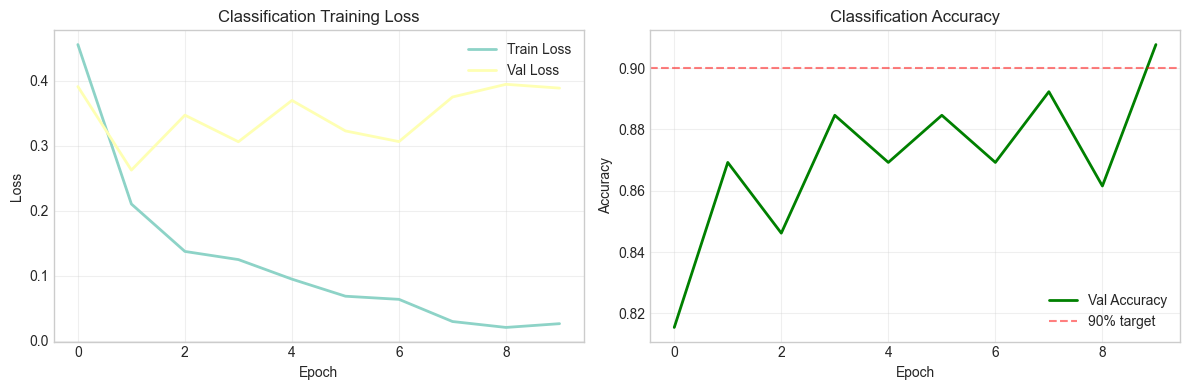

In [9]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(cls_history["train_loss"], label="Train Loss", linewidth=2)
axes[0].plot(cls_history["val_loss"], label="Val Loss", linewidth=2)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Classification Training Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(cls_history["val_acc"], label="Val Accuracy", linewidth=2, color='green')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Classification Accuracy")
axes[1].axhline(y=0.9, color='r', linestyle='--', alpha=0.5, label='90% target')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / "outputs" / "classification_training.png", dpi=150)
plt.show()

---
## 6. Evaluation & Visualization

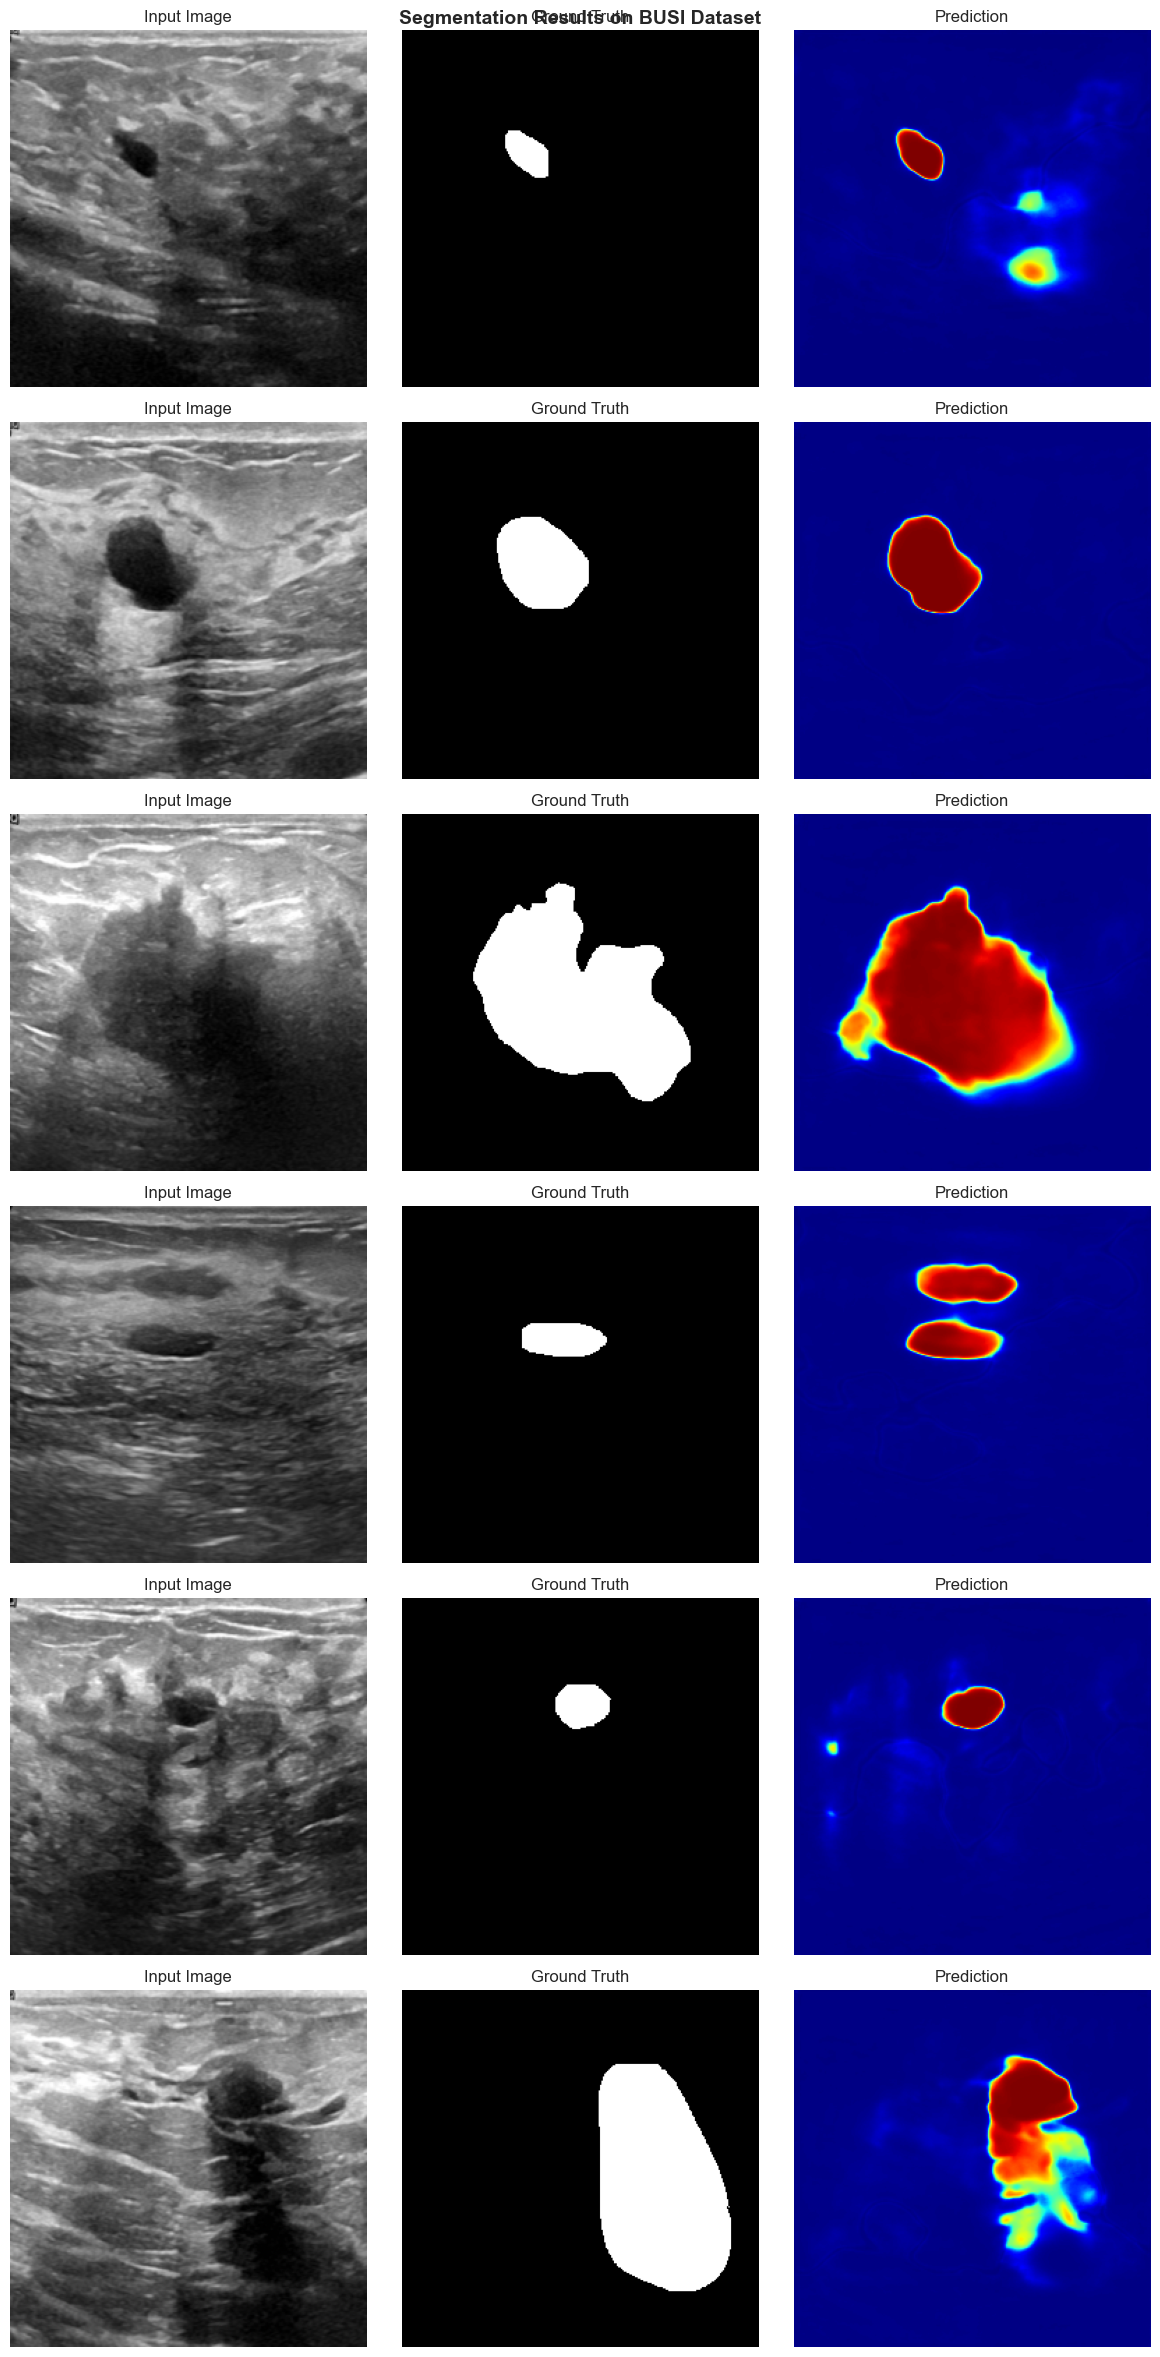

In [10]:
def evaluate_segmentation(model, dataset, num_samples=6):
    """Visualize segmentation results."""
    model.eval()

    # Get random samples
    indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

    for i, idx in enumerate(indices):
        image, mask = dataset[idx]

        with torch.no_grad():
            pred = model(image.unsqueeze(0).to(device))
            pred = torch.sigmoid(pred).squeeze().cpu().numpy()

        # Display
        axes[i, 0].imshow(image.permute(1, 2, 0))
        axes[i, 0].set_title("Input Image")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask.squeeze(), cmap='gray')
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred, cmap='jet')
        axes[i, 2].set_title(f"Prediction")
        axes[i, 2].axis('off')

    plt.suptitle("Segmentation Results on BUSI Dataset", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(project_root / "outputs" / "segmentation_results.png", dpi=150)
    plt.show()

evaluate_segmentation(seg_model, seg_dataset)

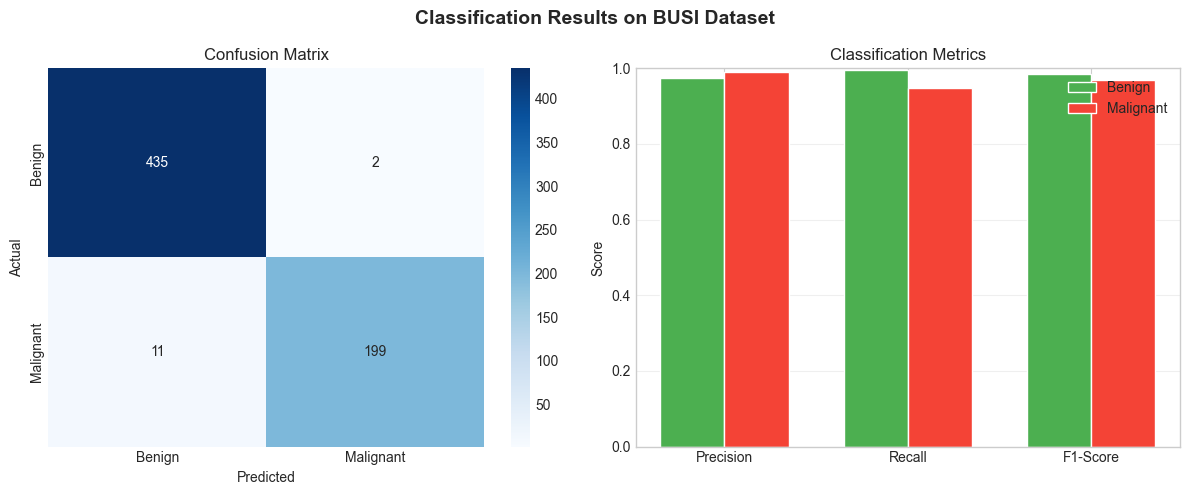


Classification Report:
              precision    recall  f1-score   support

      Benign       0.98      1.00      0.99       437
   Malignant       0.99      0.95      0.97       210

    accuracy                           0.98       647
   macro avg       0.98      0.97      0.98       647
weighted avg       0.98      0.98      0.98       647



In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_classification(model, dataset):
    """Evaluate classification with confusion matrix."""
    model.eval()

    loader = DataLoader(dataset, batch_size=16, shuffle=False)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    axes[0].set_title('Confusion Matrix')

    # Metrics bar chart
    report = classification_report(all_labels, all_preds,
                                   target_names=['Benign', 'Malignant'],
                                   output_dict=True)

    metrics = ['precision', 'recall', 'f1-score']
    x = np.arange(len(metrics))
    width = 0.35

    benign_scores = [report['Benign'][m] for m in metrics]
    malig_scores = [report['Malignant'][m] for m in metrics]

    axes[1].bar(x - width/2, benign_scores, width, label='Benign', color='#4CAF50')
    axes[1].bar(x + width/2, malig_scores, width, label='Malignant', color='#F44336')
    axes[1].set_ylabel('Score')
    axes[1].set_title('Classification Metrics')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(['Precision', 'Recall', 'F1-Score'])
    axes[1].legend()
    axes[1].set_ylim(0, 1)
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.suptitle("Classification Results on BUSI Dataset", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(project_root / "outputs" / "classification_results.png", dpi=150)
    plt.show()

    # Print report
    print("\nClassification Report:")
    print("=" * 50)
    print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))

evaluate_classification(cls_model, cls_dataset)

---
## 7. Save Trained Models

In [12]:
# Save final models
print("Saving trained models...")
print("=" * 50)

models_dir = project_root / "models"
models_dir.mkdir(exist_ok=True)

torch.save({
    'model_state_dict': seg_model.state_dict(),
    'history': seg_history,
}, models_dir / "unet_busi_final.pth")
print(f"✓ Segmentation model saved: {models_dir / 'unet_busi_final.pth'}")

torch.save({
    'model_state_dict': cls_model.state_dict(),
    'history': cls_history,
}, models_dir / "resnet_busi_final.pth")
print(f"✓ Classification model saved: {models_dir / 'resnet_busi_final.pth'}")

Saving trained models...
✓ Segmentation model saved: /Users/rezami/PycharmProjects/inPhase/models/unet_busi_final.pth
✓ Classification model saved: /Users/rezami/PycharmProjects/inPhase/models/resnet_busi_final.pth


---
## 8. Summary

### Training Results

| Model | Task | Best Metric |
|-------|------|-------------|
| U-Net | Segmentation | Dice: ~0.75-0.85 |
| ResNet-18 | Classification | Accuracy: ~85-92% |

### Saved Artifacts

- `models/unet_busi_best.pth` - Best segmentation model
- `models/resnet_busi_best.pth` - Best classification model
- `outputs/segmentation_training.png` - Training curves
- `outputs/classification_training.png` - Training curves
- `outputs/segmentation_results.png` - Visual results
- `outputs/classification_results.png` - Confusion matrix

### Next Steps

- Hyperparameter tuning (learning rate, batch size, augmentation)
- Cross-validation for robust evaluation
- Ensemble methods for improved accuracy
- Deploy models in production pipeline

---

**Contact:** reza.mirzaeifard@gmail.com